In [1]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from torch.optim.lr_scheduler import StepLR

In [2]:
np.random.seed(24)

folder_path = './data'

# get all file name
csv_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]

# read all data
date_test = []
dataframes_train = []
dataframes_test = {}
for file in csv_files:
    df = pd.read_csv(file)
    df = df[2:]
    df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)
    df['H-L'] = df['High'] - df['Low']
    df['O-C'] = df['Close'] - df['Open']
    df['7_DAYS_MA'] = df['Close'].rolling(window=7).mean()
    df['14_DAYS_MA'] = df['Close'].rolling(window=14).mean()
    df['21_DAYS_MA'] = df['Close'].rolling(window=21).mean()
    df['7_DAYS_STD_DEV'] = df['Close'].rolling(window=7).std()
    df['7_DAYS_MA'] = df['7_DAYS_MA'].fillna(df['7_DAYS_MA'][8])
    df['14_DAYS_MA'] = df['14_DAYS_MA'].fillna(df['14_DAYS_MA'][15])
    df['21_DAYS_MA'] = df['21_DAYS_MA'].fillna(df['21_DAYS_MA'][22])
    df['7_DAYS_STD_DEV'] = df['7_DAYS_STD_DEV'].fillna(df['7_DAYS_STD_DEV'][8])
    indices = df.loc[df['Price'] == '2017-04-04'].index
    dataframes_train.append(df[:indices[0]-2])
    dataframes_test[file] = df[indices[0]-2:].iloc[:, 1:]
    date_test = df[indices[0]-2:].iloc[:, 0]

# combine
df_train = pd.concat(dataframes_train, ignore_index=True)
date_train = df_train.iloc[:, 0]
df_train = df_train.iloc[:, 1:]

print(df_train)
print(dataframes_test[csv_files[0]])

train_missing = df_train.isnull().any()
print("Whether df has None:", train_missing)

           Close       High        Low       Open      Volume       H-L  \
0      88.790199  89.779714  86.811165  88.295439  21098100.0  2.968549   
1      88.356331  91.157428  86.445799  86.773101  22183000.0  4.711629   
2      87.343964  89.475235  85.631337  89.338224  20406200.0  3.843898   
3      94.635971  95.130731  89.399134  91.180269  25610700.0  5.731597   
4      99.065941  99.918456  93.243014  93.478974  36460800.0  6.675442   
...          ...        ...        ...        ...         ...       ...   
10060  23.288853   23.35703   23.15932  23.220678  19327725.0   0.19771   
10061  23.404743  23.486555  23.254759  23.288845  18214174.0  0.231796   
10062  23.418385  23.479742  23.282032  23.309304  15803465.0   0.19771   
10063  23.322937  23.438835  23.288848  23.322937  19616837.0  0.149987   
10064  23.343386   23.41838  23.247939  23.254759  19064752.0  0.170441   

            O-C  7_DAYS_MA  14_DAYS_MA  21_DAYS_MA  7_DAYS_STD_DEV  
0       0.49476  91.150906   9

In [3]:
# normilize
min_values = df_train.min()
max_values = df_train.max()

df_train = (df_train - min_values) / (max_values - min_values)

a = (max_values - min_values)['Close']
b = min_values['Close']
print(min_values, max_values)
print(df_train)
X_train = df_train.iloc[:, 4:].astype('float32').to_numpy()
y_train = df_train.iloc[:, 0].astype('float32').to_numpy()

Close              6.591944
High               6.728431
Low                6.445341
Open               6.627327
Volume             694200.0
H-L                0.059761
O-C              -17.605467
7_DAYS_MA          6.727712
14_DAYS_MA         6.824843
21_DAYS_MA         6.862997
7_DAYS_STD_DEV     0.022695
dtype: object Close              213.072723
High               214.976895
Low                211.699372
Open               213.763633
Volume            299829377.0
H-L                 23.704396
O-C                  6.787033
7_DAYS_MA          211.840184
14_DAYS_MA         210.991321
21_DAYS_MA         210.413114
7_DAYS_STD_DEV      10.745394
dtype: object
          Close      High       Low      Open    Volume       H-L       O-C  \
0      0.398092  0.398809  0.391543  0.394272   0.06821  0.123021  0.742041   
1       0.39599  0.405424  0.389763  0.386923  0.071836  0.196741  0.786664   
2      0.391087  0.397347  0.385795  0.399307  0.065897  0.160042      0.64   
3      0.426403  0

In [4]:
# creat model
class ANNModel(nn.Module):
    def __init__(self, input_dim):
        super(ANNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 3),
            nn.ReLU(),
            nn.Linear(3, 1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.model(x)

In [29]:
# train
def train_model(model, X_train, y_train, epochs=50, batch_size=32):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.004)
    scheduler = StepLR(optimizer, step_size=150, gamma=0.1)

    # tensor
    X_train_tensor = torch.tensor(X_train, dtype=torch.float)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float).view(-1, 1)

    dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        scheduler.step()

        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader):.6f}")

model = ANNModel(input_dim=X_train.shape[1])
train_model(model, X_train, y_train, epochs=170, batch_size=128)

# save
# torch.save(model.state_dict(), './model_state_dict.pth')

Epoch [10/170], Loss: 0.000233
Epoch [20/170], Loss: 0.000112
Epoch [30/170], Loss: 0.000061
Epoch [40/170], Loss: 0.000047
Epoch [50/170], Loss: 0.000040
Epoch [60/170], Loss: 0.000035
Epoch [70/170], Loss: 0.000033
Epoch [80/170], Loss: 0.000031
Epoch [90/170], Loss: 0.000031
Epoch [100/170], Loss: 0.000031
Epoch [110/170], Loss: 0.000030
Epoch [120/170], Loss: 0.000028
Epoch [130/170], Loss: 0.000029
Epoch [140/170], Loss: 0.000029
Epoch [150/170], Loss: 0.000026
Epoch [160/170], Loss: 0.000025
Epoch [170/170], Loss: 0.000025


In [5]:
model = ANNModel(input_dim=X_train.shape[1])
model.load_state_dict(torch.load('./model_state_dict.pth'))

<All keys matched successfully>

In [6]:
# evaluate
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float).view(-1, 1)
        y_pred_scaled = model(X_test_tensor).numpy()
        y_pred = y_pred_scaled * a + b
        y_true = y_test_tensor.numpy() * a + b
        rmse = np.sqrt(np.sum((y_true - y_pred)**2) / len(y_true))
        mape = (np.sum((y_true - y_pred)/y_true) / len(y_true)) * 100
        mbe = np.sum(y_true - y_pred) / len(y_true)
        
        print(f"RMSE: {rmse:.2f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"MBE: {mbe:.4f}")

        return y_pred

pred_close = {}
for file in csv_files:
    df_test = dataframes_test[file]
    df_test = (df_test - min_values) / (max_values - min_values)
    
    X_test = df_test.iloc[:, 4:].astype('float32').to_numpy()
    y_test = df_test.iloc[:, 0].astype('float32').to_numpy()

    print(file)
    y_pred = evaluate_model(model, X_test, y_test)
    pred_close[file] = y_pred.ravel()

./data\Goldman Sachs_stock_data.csv
RMSE: 3.24
MAPE: 0.18%
MBE: 0.4096
./data\Johnson and Johnson_stock_data.csv
RMSE: 1.27
MAPE: 0.05%
MBE: 0.0570
./data\JP Morgan Chase and Co_stock_data.csv
RMSE: 1.17
MAPE: 0.11%
MBE: 0.0997
./data\Nike_stock_data.csv
RMSE: 1.00
MAPE: 0.06%
MBE: 0.0546
./data\Pfizer_stock_data.csv
RMSE: 0.31
MAPE: -0.12%
MBE: -0.0286


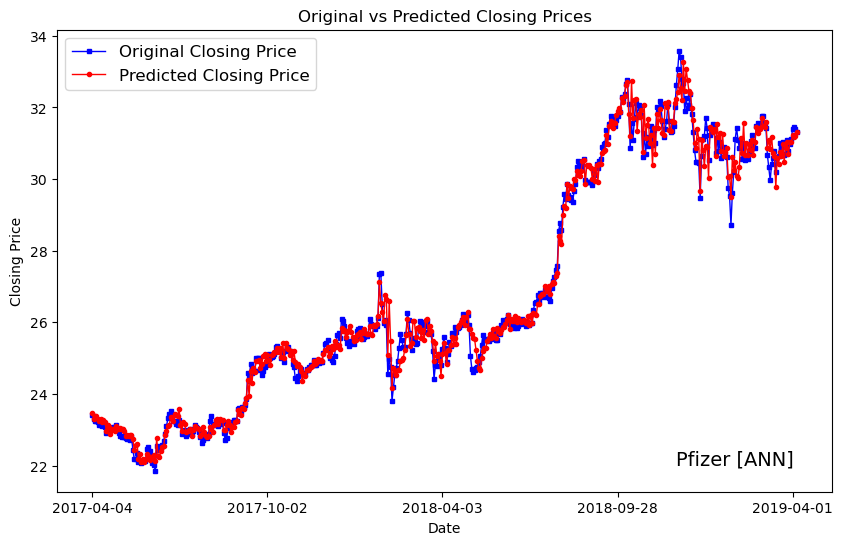

In [23]:
import matplotlib.pyplot as plt

index = 4
dates = date_test.to_numpy()
original_prices = dataframes_test[csv_files[index]]['Close']
predicted_prices = pred_close[csv_files[index]]

# df
data = pd.DataFrame({
    'Date': dates,
    'Original Closing Price': original_prices,
    'Predicted Closing Price': predicted_prices
})

# name of stock and method
method = '[ANN]'
stocks = ['Goldman Sachs ',
         'JNJ ',
         'JP Morgan ',
         'Nike ',
         'Pfizer ']

plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Original Closing Price'], 's-', label='Original Closing Price', color='blue', linewidth=1, markersize=3)
plt.plot(data['Date'], data['Predicted Closing Price'], 'o-', label='Predicted Closing Price', color='red', linewidth=1, markersize=3)

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Original vs Predicted Closing Prices')
plt.legend()

# show date
plt.xticks(data['Date'][::125])
plt.text(0.95, 0.05, stocks[index]+method,
         horizontalalignment='right',
         verticalalignment='bottom',
         transform=plt.gca().transAxes,
        fontsize=14)
plt.legend(fontsize=12, loc='upper left')

plt.savefig('./pictures/' + stocks[index] +'.png')
plt.show()